# Announcements

**Project 1**<br>

**Practicing makes much difference.** 

**Assignments and Projects**<br>
For assistance in your assignment or project, if you are close to the deadline (e.g., one day earlier), it may be harder to find help.


## Week 10 – Unsupervised Machine Learning


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# Setup

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Clustering

## K-Means

Let's start by generating some blobs:

In [3]:
from sklearn.datasets import make_blobs

In [4]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [5]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's plot them:

In [6]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


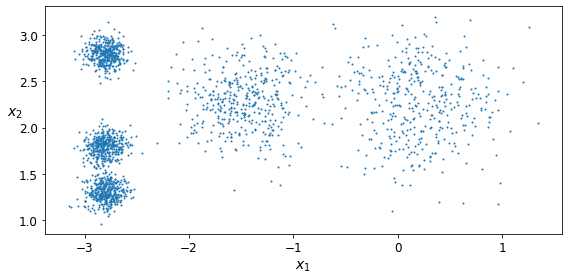

In [7]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [19]:
from sklearn.cluster import KMeans

In [20]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [21]:
y_pred

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

In [22]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [23]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [24]:
kmeans.labels_

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

Of course, we can predict the labels of new instances:

In [25]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [65]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=20, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

In [66]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


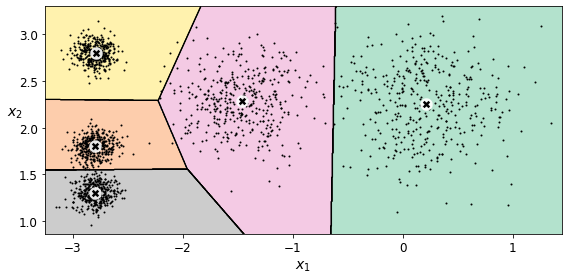

In [67]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

### K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [68]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

And let's plot this:

Saving figure kmeans_algorithm_plot


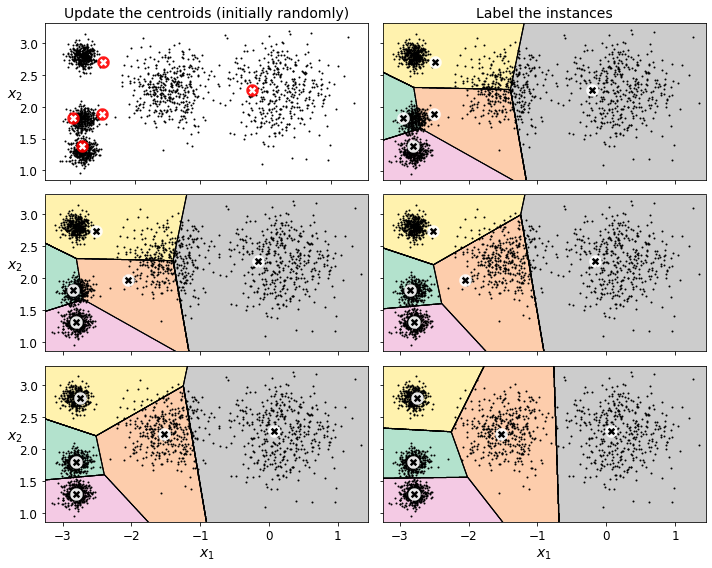

In [76]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

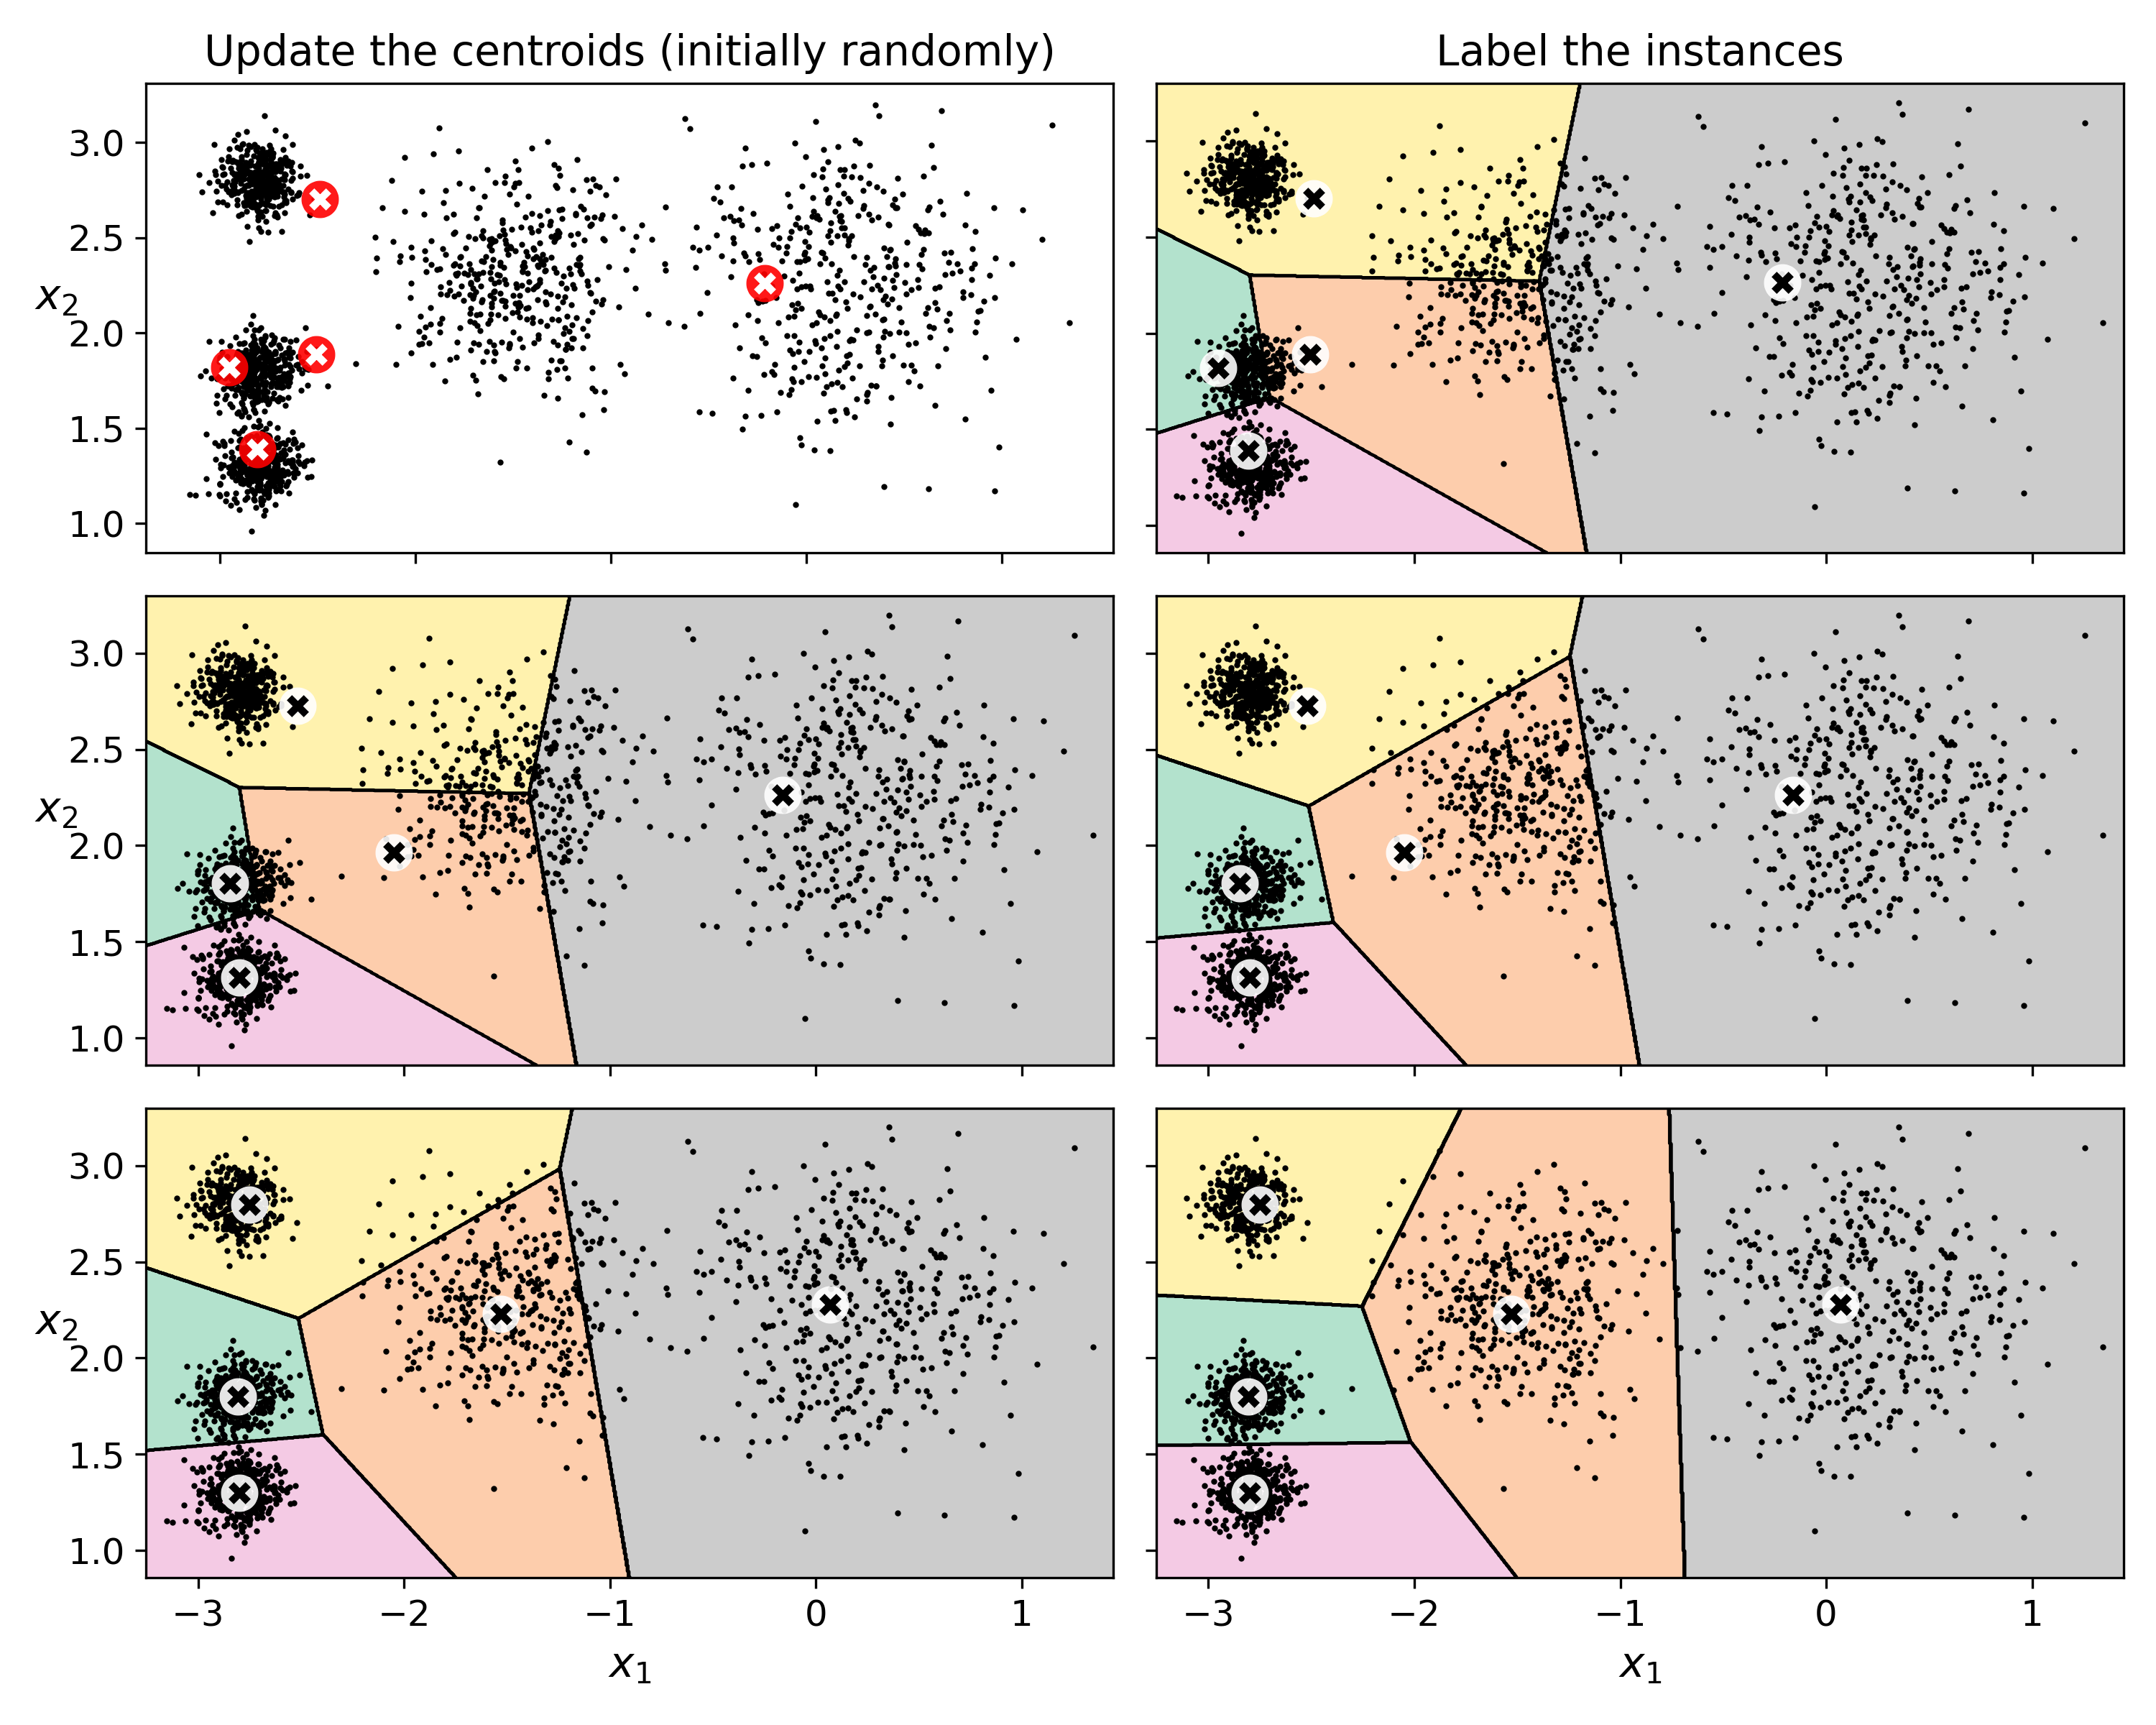

In [80]:
from IPython.display import Image
%matplotlib inline
Image(filename='./images/unsupervised_learning/kmeans_algorithm_plot.png', width=800) 

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [81]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


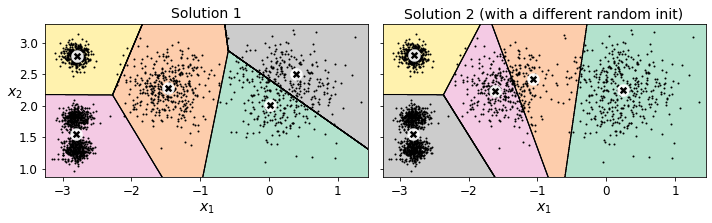

In [83]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [20]:
kmeans.inertia_

211.5985372581684

Inertia is the sum of the squared distances between each training instance and its closest centroid.

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [84]:
kmeans_rnd_init1.inertia_

223.29108572819044

In [85]:
kmeans_rnd_init2.inertia_

237.46249169442856

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [86]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=11)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

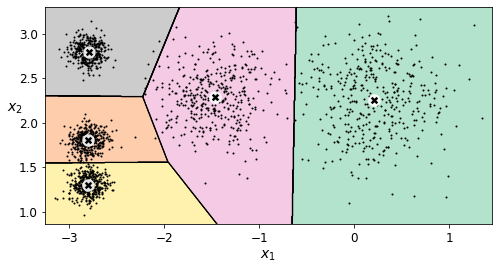

In [87]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

Saving figure bad_n_clusters_plot


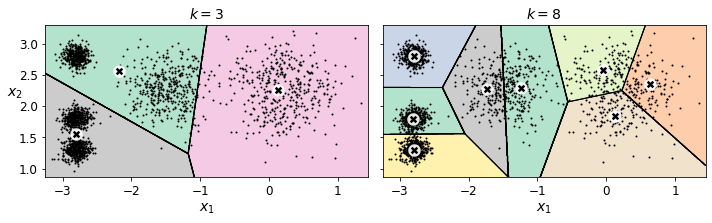

In [88]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [89]:
kmeans_k3.inertia_

653.2167190021556

In [90]:
kmeans_k8.inertia_

119.1198341610289

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [91]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


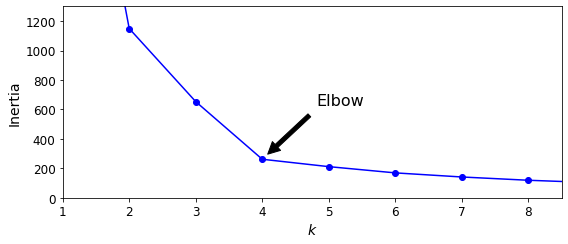

In [92]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

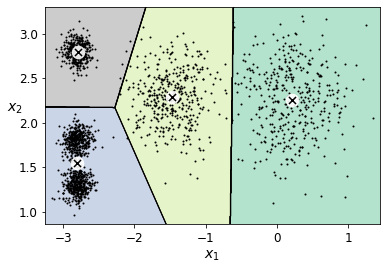

In [30]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [31]:
from sklearn.metrics import silhouette_score

In [32]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [33]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


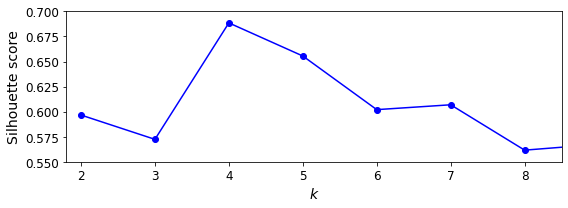

In [34]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

### Limits of K-Means

In [93]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

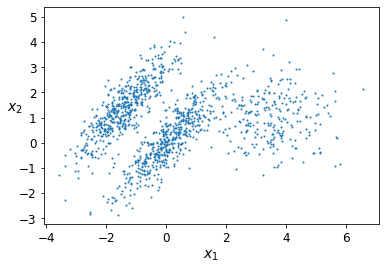

In [94]:
plot_clusters(X)

In [96]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


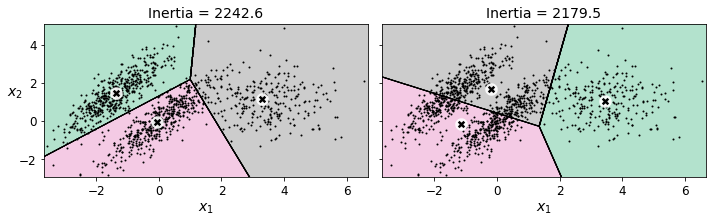

In [97]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

### Using Clustering for Preprocessing

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [102]:
from sklearn.datasets import load_digits

In [103]:
X_digits, y_digits = load_digits(return_X_y=True)

In [104]:
X_digits

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

Let's split it into a training set and a test set:

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [107]:
from sklearn.linear_model import LogisticRegression

In [108]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [109]:
log_reg.score(X_test, y_test)

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [110]:
from sklearn.pipeline import Pipeline

In [111]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [48]:
pipeline.score(X_test, y_test)

0.98

How much the error is reduced?

In [112]:
1 - (1 - 0.977777) / (1 - 0.968888)

0.28570969400874346

How about that? We reduced the error rate by over 28%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [113]:
from sklearn.model_selection import GridSearchCV

In [114]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=   2.1s
[CV] END ..............................kmeans__n_clusters=36; total time=   2.7s
[CV] END ..............................kmeans__n_clusters=36; total time=   3.0s
[CV] END ..............................kmeans__n_clusters=36; total time=   2.4s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.8s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.5s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=38; total time=   3.3s
[CV] END ..............................kmeans__n_clusters=38; total time=   2.8s
[CV] END ..............................kmeans__n_clusters=38; total time=   2.8s
[CV] END ..............................kmeans__n_clusters=39; total time=   2.4s
[CV] END ..............................kmeans__n_clusters=39; total time=   2.5s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=   3.4s
[CV] END ..............................kmeans__n_clusters=70; total time=   4.1s
[CV] END ..............................kmeans__n_clusters=70; total time=   4.8s
[CV] END ..............................kmeans__n_clusters=70; total time=   4.2s
[CV] END ..............................kmeans__n_clusters=71; total time=   4.4s
[CV] END ..............................kmeans__n_clusters=71; total time=   4.1s
[CV] END ..............................kmeans__n_clusters=71; total time=   3.9s
[CV] END ..............................kmeans__n_clusters=72; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=72; total time=   2.8s
[CV] END ..............................kmeans__n_clusters=72; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=73; total time=   3.2s
[CV] END ..............................kmeans__n_clusters=73; total time=   3.1s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [115]:
grid_clf.best_params_

{'kmeans__n_clusters': 88}

In [116]:
grid_clf.score(X_test, y_test)

0.9844444444444445

The performance improved most with $k=88$, so 88 it is.

# Similarity-based Learning

Similiarity-based approaches in machine learning come from the idea that the best way to make predictions is simply to look at what has worked in the past and predict the same thing again. The fundamental concepts required to build a system based on this idea are feature spaces and measures of similarity.

## What is a metric?

The "distance" $d$ between two points in a vector space must satisfy the following requirements:
* It is **non-negative**: $d(x,y) \geq 0$ for all $x$, $y$, with $d(x,y) = 0$ if and only if $x = y$
* It is **symmetric**: $d(x,y) = d(y,x)$
* It satisfies the **triangle inequality**: $d(x,y) \leq d(x,z) + d(z,y)$

Some common measures of distance:

### Euclidean distance

This is perhaps the most commonly used distance metric: $d(X,Y) = \sqrt{(X_0-Y_0)^2 + (X_1-Y_1)^2}$.

In [33]:
import numpy as np
import math as ma
import matplotlib.pyplot as plt
%matplotlib inline

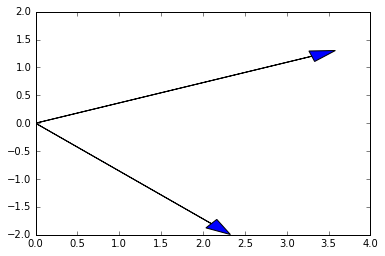

In [28]:
X = np.array([3.3, 1.2])
Y = np.array([2.1, -1.8])

plt.arrow(0,0,*X, head_width=0.2);
plt.arrow(0,0,*Y, head_width=0.2);
plt.xlim([0, 4]);
plt.ylim([-2,2]);
plt.show();

In [18]:
# Euclidean distance manually:
ma.sqrt(np.sum((X-Y)**2))

3.2310988842807022

In [15]:
# numpy norm:
np.linalg.norm(X-Y)

3.2310988842807022

### More general Minkowski distance

In a d-dimensional vector space, the Minkowski distance of order $p$ is defined as:

$d_p(X,Y) = \left(\sum_{i=1}^{d} \left|X_i - Y_i\right|^p \right)^{1/p}$

The Euclidean distance is a special case of the Minkowski distance with $p=2$. 

Some other common cases include:

* The Manhattan distance: $p = 1$
* The Chebyshev distance: $p = \infty$, where $d_\infty(X,Y) = \max_{i = 0,\ldots,n}\left| X_i - Y_i \right|$

In [34]:
import scipy.spatial.distance as dst

In [25]:
# Manhattan distance
dst.cdist(np.expand_dims(X, axis=0),np.expand_dims(Y, axis=0),'cityblock')

array([[ 4.2]])

In [26]:
# Chebyshev distance
dst.cdist(np.expand_dims(X, axis=0),np.expand_dims(Y, axis=0),'chebyshev')

array([[ 3.]])

## Scaling the Axes

The Euclidean distance can be written in (suggestive) vector notation as:

$d^2(X,Y) = (X-Y)^T I_{n \times n} (X-Y)$

Instead of the $n \times n$ identity matrix, we could use and positive definite matrix. 

A **positive definite** matrix is defined as a matrix $M$ for which $z^T M z \geq 0$ for all real vectors $z$, with equality only if $z$ is the vector of all zeros.

We can use this matrix to appropriately rescale the axes, for example to correct for high variance along a given dimension in our feature space: this gives us the Mahalanobis metric, 

$d_M(X,Y) = (X-Y)^T \Sigma^{-1} (X-Y)$,

where $\Sigma$ is the covariance matrix of your data points.

## Additional reading:

Distances between words (taking into account the context):

http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

# Let's try some clustering

In [55]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [56]:
# read in the basketball draft dataset
df = pd.read_csv('./Table5-2.csv', names=['ID','Speed','Agility','Draft'], skiprows=[0])

df.head()

,ID,Speed,Agility,Draft
0,1,2.50,6.00,no
1,2,3.75,8.00,no
2,3,2.25,5.50,no
3,4,3.25,8.25,no
4,5,2.75,7.50,no


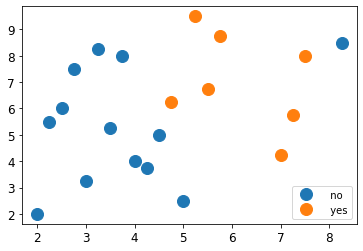

In [57]:
fig, ax = plt.subplots()
ax.margins(0.05)
groups = df.groupby('Draft')
for name, group in groups:
    ax.plot(group.Speed, group.Agility, marker='o', linestyle='', ms=12, label=name);
ax.legend(numpoints=1, loc='lower right');

## Nearest-neighbor clustering

In [58]:
# Let's fit a nearest-neighbor model to our data, using Euclidean distance...
nearest_neighbor_model = NearestNeighbors(1, metric='euclidean').fit(df[['Speed','Agility']], df['Draft'])

In [59]:
# OK, now let's find the nearest neighbors for some new data points!
samples = np.array([[7,7],[5,5]]) # samples to classify, in [speed, agility] format

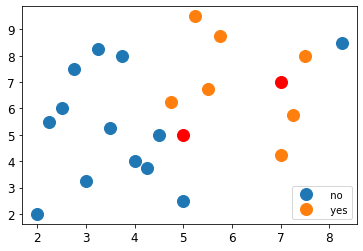

In [60]:
fig, ax = plt.subplots()
ax.margins(0.05)
groups = df.groupby('Draft')
for name, group in groups:
    ax.plot(group.Speed, group.Agility, marker='o', linestyle='', ms=12, label=name);
ax.legend(numpoints=1, loc='lower right');
ax.plot(samples[:,0],samples[:,1], marker='o', linestyle='', ms=12, c='red');

In [61]:
nearest_neighbor_model.kneighbors(samples, return_distance=True)

(array([[1.11803399],
        [0.5       ]]),
 array([[18],
        [ 5]]))

In [62]:
df.Draft.iloc[nearest_neighbor_model.kneighbors(samples, return_distance=False).ravel()] 
# the kneighbors method returns the index of the nearest neighbors....

18      yes
5        no
Name: Draft, dtype: object

In [63]:
nearest_neighbor_model.kneighbors([[7,7],[5,5]], return_distance=False).ravel()

array([18,  5])

## K-Nearest Neighbors Classifier

The NearestNeighbors function helps us recover the neighbors that are closest to the desired data point; but if we're interested in using k-nearest neighbors for classification, we can use KNeighborsClassifier.

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
# define model and train it on the input data
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean').fit(df[['Speed','Agility']], df['Draft'])

In [66]:
# predict classes for "samples", using k nearest neighbors
knn_model.predict(samples)

array(['  yes', '  no'], dtype=object)

In [67]:
from sklearn.cluster import KMeans

In [68]:
kmeans_model = KMeans(2).fit(df[['Speed','Agility']])

In [69]:
df['Clust'] = kmeans_model.predict(df[['Speed','Agility']])

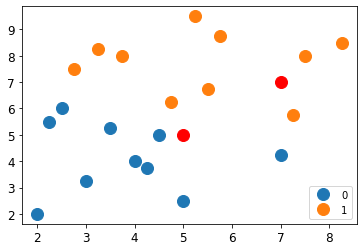

In [70]:
fig, ax = plt.subplots()
ax.margins(0.05)
groups = df.groupby('Clust')
for name, group in groups:
    ax.plot(group.Speed, group.Agility, marker='o', linestyle='', ms=12, label=name);
ax.legend(numpoints=1, loc='lower right');
ax.plot(samples[:,0],samples[:,1], marker='o', linestyle='', ms=12, c='red');

In [101]:
help(KMeans)

Help on class KMeans in module sklearn.cluster.k_means_:

class KMeans(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin)
 |  K-Means clustering
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, optional, default: 8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  max_iter : int, default: 300
 |      Maximum number of iterations of the k-means algorithm for a
 |      single run.
 |  
 |  n_init : int, default: 10
 |      Number of time the k-means algorithm will be run with different
 |      centroid seeds. The final results will be the best output of
 |      n_init consecutive runs in terms of inertia.
 |  
 |  init : {'k-means++', 'random' or an ndarray}
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up co